## Dataset import and exploration
- https://www.kaggle.com/shelvigarg/wine-quality-dataset
- Refer to https://github.com/better-data-science/TensorFlow/blob/main/003_TensorFlow_Classification.ipynb for detailed preparation instructions

In [7]:
import os
import numpy as np
import pandas as pd
import warnings
from datetime import datetime
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (24, 6)
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' 
warnings.filterwarnings('ignore')

df = pd.read_csv('data/winequalityN.csv')
df.sample(5)

,type,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
1155,white,7.6,0.330,0.36,2.10,0.034,26.0,172.0,0.99440,3.42,0.48,10.5,4
6406,red,7.1,0.270,0.60,2.10,0.074,17.0,25.0,0.99814,3.38,0.72,10.6,6
224,white,6.3,0.495,0.22,1.80,0.046,31.0,140.0,0.99290,3.39,NaN,10.4,6
1206,white,7.0,0.260,0.46,15.55,0.037,61.0,171.0,0.99860,2.94,0.35,8.8,6
782,white,6.9,0.220,0.37,15.00,0.053,59.0,178.0,0.99920,3.37,0.82,9.5,7


In [8]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


# Prepare the data
df = df.dropna()
df['is_white_wine'] = [1 if typ == 'white' else 0 for typ in df['type']]
df['is_good_wine'] = [1 if quality >= 6 else 0 for quality in df['quality']]
df.drop(['type', 'quality'], axis=1, inplace=True)

# Train/test split
X = df.drop('is_good_wine', axis=1)
y = df['is_good_wine']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, random_state=42
)

# Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

<br>

## Modelling
- Let's declare a function that builds and trains the model
- We're doing this because we'll train the exact same model multiple times

In [11]:
import tensorflow as tf
tf.random.set_seed(42)

In [12]:
def build_and_train(callbacks: list, num_epochs: int = 5) -> tf.keras.Sequential:
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])

    model.compile(
        loss=tf.keras.losses.binary_crossentropy,
        optimizer=tf.keras.optimizers.Adam(),
        metrics=[tf.keras.metrics.BinaryAccuracy(name='accuracy')]
    )

    model.fit(
        X_train_scaled, 
        y_train, 
        epochs=num_epochs,
        validation_data=(X_test_scaled, y_test),
        callbacks=callbacks,
        verbose=0
    )
    
    return model

<br>

## Basic custom callback
- We'll define what happens on:
    - **Train begin** - we'll just print the time at which the training started
    - **Train end** - we'll print the time at which the training finsihed, how much time did the training last, and evaluation metrics (accuracy, precision, recall, f1) on the test set

In [13]:
class MyCallback(tf.keras.callbacks.Callback):
    def __init__(self):
        self.time_started = None
        self.time_finished = None
        
    def on_train_begin(self, logs=None):
        self.time_started = datetime.now()
        print(f'TRAINING STARTED | {self.time_started}\n')
        
    def on_train_end(self, logs=None):
        self.time_finished = datetime.now()
        train_duration = str(self.time_finished - self.time_started)
        print(f'\nTRAINING FINISHED | {self.time_finished} | Duration: {train_duration}')
        
        tl = f"Training loss:       {logs['loss']:.5f}"
        ta = f"Training accuracy:   {logs['accuracy']:.5f}"
        vl = f"Validation loss:     {logs['val_loss']:.5f}"
        va = f"Validation accuracy: {logs['val_accuracy']:.5f}"
        
        print('\n'.join([tl, vl, ta, va]))

- Pass in the callback like this:

In [14]:
model = build_and_train(
    callbacks=[MyCallback()]
)

TRAINING STARTED | 2023-02-21 19:12:46.562453


TRAINING FINISHED | 2023-02-21 19:12:54.905698 | Duration: 0:00:08.343245
Training loss:       0.46939
Validation loss:     0.47256
Training accuracy:   0.77853
Validation accuracy: 0.77108


<br>

## Extending the callback functionality
- We'll also modify the behavior for a single epoch:
    - **Epoch begin** - just save the time to the constructor
    - **Epoch end** - Calculate epoch duration and keep track of the training and validation metrics. We'll print them in a somewhat of a visually apealing way

In [15]:
class MyCallback(tf.keras.callbacks.Callback):
    def __init__(self):
        self.time_started = None
        self.time_finished = None
        self.time_curr_epoch = None
        
    def on_train_begin(self, logs=None):
        self.time_started = datetime.now()
        print(f'TRAINING STARTED | {self.time_started}\n')
        
    def on_train_end(self, logs=None):
        self.time_finished = datetime.now()
        train_duration = str(self.time_finished - self.time_started)
        print(f'\nTRAINING FINISHED | {self.time_finished} | Duration: {train_duration}')
        
        tl = f"Training loss:       {logs['loss']:.5f}"
        ta = f"Training accuracy:   {logs['accuracy']:.5f}"
        vl = f"Validation loss:     {logs['val_loss']:.5f}"
        va = f"Validation accuracy: {logs['val_accuracy']:.5f}"
        
        print('\n'.join([tl, vl, ta, va]))
        
    def on_epoch_begin(self, epoch, logs=None):
        self.time_curr_epoch = datetime.now()
        
    def on_epoch_end(self, epoch, logs=None):
        epoch_dur = (datetime.now() - self.time_curr_epoch).total_seconds()
        tl = logs['loss']
        ta = logs['accuracy']
        vl = logs['val_loss']
        va = logs['val_accuracy']
        
        train_metrics = f"train_loss: {tl:.5f}, train_accuracy: {ta:.5f}"
        valid_metrics = f"valid_loss: {vl:.5f}, valid_accuracy: {va:.5f}"
        
        print(f"Epoch: {epoch:4} | Runtime: {epoch_dur:.3f}s | {train_metrics} | {valid_metrics}")

In [17]:
model = build_and_train(
    callbacks=[MyCallback()]
)

TRAINING STARTED | 2023-02-21 20:19:36.374187

Epoch:    0 | Runtime: 2.719s | train_loss: 0.56088, train_accuracy: 0.70290 | valid_loss: 0.49245, valid_accuracy: 0.75715
Epoch:    1 | Runtime: 0.399s | train_loss: 0.50362, train_accuracy: 0.75706 | valid_loss: 0.49112, valid_accuracy: 0.75870
Epoch:    2 | Runtime: 0.403s | train_loss: 0.49048, train_accuracy: 0.76770 | valid_loss: 0.47378, valid_accuracy: 0.77417
Epoch:    3 | Runtime: 0.384s | train_loss: 0.47850, train_accuracy: 0.77466 | valid_loss: 0.47471, valid_accuracy: 0.76334
Epoch:    4 | Runtime: 0.383s | train_loss: 0.47294, train_accuracy: 0.77776 | valid_loss: 0.47084, valid_accuracy: 0.77030

TRAINING FINISHED | 2023-02-21 20:19:40.849785 | Duration: 0:00:04.475598
Training loss:       0.47294
Validation loss:     0.47084
Training accuracy:   0.77776
Validation accuracy: 0.77030


<br>

## Tweaking the functionality even further
- We'll declare a function that plots training loss vs. validation loss and training accuracy vs. validation accuracy (`_plot_model_performance()``
- We'll plot ot on training end

In [18]:
class MyCallback(tf.keras.callbacks.Callback):
    def __init__(self):
        self.time_started = None
        self.time_finished = None
        self.time_curr_epoch = None
        self.num_epochs = 0
        self._loss, self._acc, self._val_loss, self._val_acc = [], [], [], []
        
    def _plot_model_performance(self):
        fig, (ax1, ax2) = plt.subplots(1, 2)
        fig.suptitle('Model performance', size=20)
        
        ax1.plot(range(self.num_epochs), self._loss, label='Training loss')
        ax1.plot(range(self.num_epochs), self._val_loss, label='Validation loss')
        ax1.set_xlabel('Epoch', size=14)
        ax1.set_ylabel('Loss', size=14)
        ax1.legend()
        
        ax2.plot(range(self.num_epochs), self._acc, label='Training accuracy')
        ax2.plot(range(self.num_epochs), self._val_acc, label='Validation Accuracy')
        ax2.set_xlabel('Epoch', size=14)
        ax2.set_ylabel('Accuracy', size=14)
        ax2.legend()
        
    def on_train_begin(self, logs=None):
        self.time_started = datetime.now()
        print(f'TRAINING STARTED | {self.time_started}\n')
        
    def on_train_end(self, logs=None):
        self.time_finished = datetime.now()
        train_duration = str(self.time_finished - self.time_started)
        print(f'\nTRAINING FINISHED | {self.time_finished} | Duration: {train_duration}')
        
        tl = f"Training loss:       {logs['loss']:.5f}"
        ta = f"Training accuracy:   {logs['accuracy']:.5f}"
        vl = f"Validation loss:     {logs['val_loss']:.5f}"
        va = f"Validation accuracy: {logs['val_accuracy']:.5f}"
        
        print('\n'.join([tl, vl, ta, va]))
        self._plot_model_performance()
        
    def on_epoch_begin(self, epoch, logs=None):
        self.time_curr_epoch = datetime.now()
        
    def on_epoch_end(self, epoch, logs=None):
        self.num_epochs += 1
        epoch_dur = (datetime.now() - self.time_curr_epoch).total_seconds()
        tl = logs['loss']
        ta = logs['accuracy']
        vl = logs['val_loss']
        va = logs['val_accuracy']
        
        self._loss.append(tl); self._acc.append(ta); self._val_loss.append(vl); self._val_acc.append(va)
        
        train_metrics = f"train_loss: {tl:.5f}, train_accuracy: {ta:.5f}"
        valid_metrics = f"valid_loss: {vl:.5f}, valid_accuracy: {va:.5f}"
        
        print(f"Epoch: {epoch:4} | Runtime: {epoch_dur:.3f}s | {train_metrics} | {valid_metrics}")

TRAINING STARTED | 2023-02-21 20:20:49.285456

Epoch:    0 | Runtime: 2.108s | train_loss: 0.54322, train_accuracy: 0.72573 | valid_loss: 0.48630, valid_accuracy: 0.76102
Epoch:    1 | Runtime: 0.429s | train_loss: 0.49762, train_accuracy: 0.75919 | valid_loss: 0.49752, valid_accuracy: 0.74787
Epoch:    2 | Runtime: 0.408s | train_loss: 0.48723, train_accuracy: 0.76789 | valid_loss: 0.47111, valid_accuracy: 0.76953
Epoch:    3 | Runtime: 0.440s | train_loss: 0.47493, train_accuracy: 0.77137 | valid_loss: 0.47851, valid_accuracy: 0.76179
Epoch:    4 | Runtime: 0.422s | train_loss: 0.47059, train_accuracy: 0.77776 | valid_loss: 0.47445, valid_accuracy: 0.76953
Epoch:    5 | Runtime: 0.396s | train_loss: 0.46289, train_accuracy: 0.78008 | valid_loss: 0.46836, valid_accuracy: 0.76643
Epoch:    6 | Runtime: 0.514s | train_loss: 0.45723, train_accuracy: 0.78337 | valid_loss: 0.46535, valid_accuracy: 0.77881
Epoch:    7 | Runtime: 0.533s | train_loss: 0.45114, train_accuracy: 0.78665 | valid_

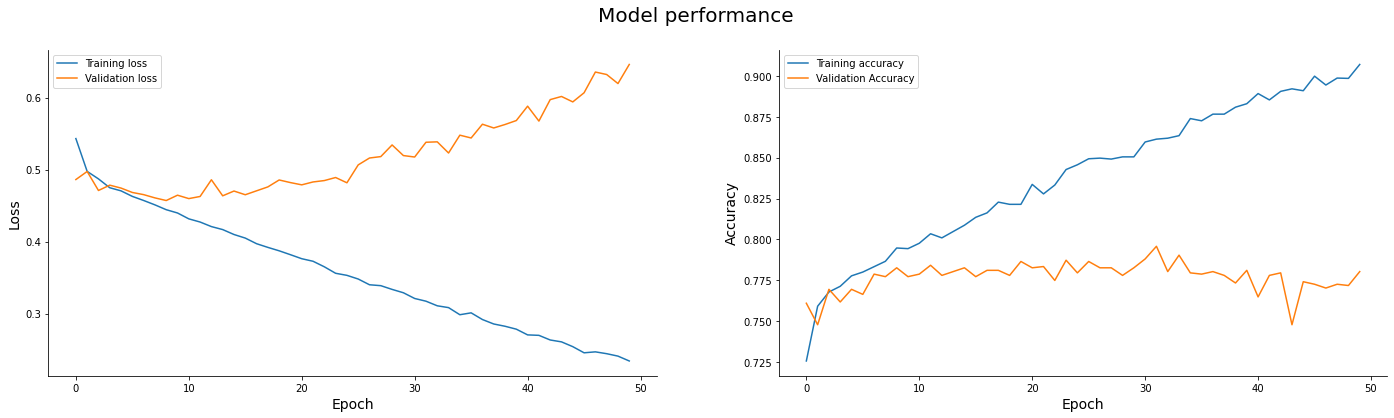

In [19]:
model = build_and_train(
    callbacks=[MyCallback()],
    num_epochs=50
)